<a href="https://colab.research.google.com/github/serciex/lane-change/blob/main/V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing Prerequisites

In [2]:
!pip install pygame
!pip install highway-env

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 kB 8.4 MB/s eta 0:00:00


Testing

In [3]:
#Import Libraries
from os import truncate
import math
import gymnasium
import highway_env
from matplotlib import pyplot as plt
import pygame
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
import gym
from random import randint
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from collections import deque
import random
import torch.optim as optim
import tqdm

# Workaround for gym compatibility
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_

%matplotlib inline

Environment Definition

In [4]:
# Configure Environment Conditions
config = {
    "lanes_count": 3,
    "lane_width": 3.75,
    "observation": {
        "type": "Kinematics",
        "features": ["x", "y", "vx", "vy", "heading", "lat_off"]
    },
    "action": {"type": "ContinuousAction"},"ego_spawn_random": True,
    "policy_frequency": 10,
}
env = gymnasium.make('highway-v0', render_mode='rgb_array', config=config)
frames = []

# Action Setup
highway_env.envs.common.action.ContinuousAction(env, lateral=True,
                                                longitudinal=True)

IDM Controller

In [5]:
# Environment Manager
class ENV(env.__class__):
  """
  s = (v,a,x,y,thetha,id,w,c) ∈ S

  Lateral Agent State:
  Obs Data:
  x = vehicle x position (x)
  y = vehicle y position (y)
  v = vehicle speed (vx)
  thetha = yaw angle (heading)

  Input:
  a = longitudinal acceleration (longitudinal_control)
  id = target lane id
  w = lane width
  c = road curvature

  Extra Data:
  vy = lateral rate (vy)
  delta_lat_deviation = change in lateral deviation (lat_off)

  """
  def __init__(self, obs, desired_parameters, control_parameters):
    self.obs = obs
    # Unpack initial parameters: [s0, v0]
    self.s0, self.v0 = desired_parameters

    # Unpack control parameters: [a, b, delta, T]
    self.a, self.b, self.delta, self.T = control_parameters

  def ego_state_idm(self):
      ax, ay, avx, avy, athetha, _ = self.obs[0]
      self._ego_state_idm = {"x": ax, "y": ay, "vx": avx,"thetha": athetha,
                         "longitudinal_acceleration":self.a}

      return self._ego_state_idm

  def update(self,obs):
    self.obs = obs

  def ego_state_agent(self,target_id):
      ax, ay, avx, avy, athetha, _ = self.obs[0]
      vehicle = env.unwrapped.vehicle

      # Control Parameters
      self.id = target_id

      # Environment Parameters
      self.s,_ = vehicle.lane.local_coordinates(vehicle.position)
      self.w = vehicle.lane.width
      self.c = vehicle.lane.heading_at(np.clip(
          vehicle.lane.local_coordinates(vehicle.position)[0],
          0, vehicle.lane.length))
      self.v = math.sqrt(avx**2+avy**2)

      self._ego_state_agent = {"x": ax, "y": ay, "vx": self.v,"thetha": athetha,
                         "lane_width":self.w,"lane_id":self.id,
                         "self_curvature":self.c,
                         "longitudinal_acceleration":self.a}

      return self._ego_state_agent

  def longitudinal_lead_state(self):
      # Lead State Parameters on the same Lane (5 columns: presence, x, y, vx, vy)
      ego_vehicle = env.unwrapped.vehicle
      lead_vehicle = env.unwrapped.road.neighbour_vehicles(ego_vehicle, lane_index=ego_vehicle.lane_index)[0]

      if lead_vehicle:
          gap = lead_vehicle.position[0] - ego_vehicle.position[0]
          delta_velocity = ego_vehicle.velocity[0] - lead_vehicle.velocity[0]
          self._longitudinal_lead_state = {"x": gap, "vx": delta_velocity}
      else:
          self._longitudinal_lead_state = {"x": 10, "vx": 0}

      return self._longitudinal_lead_state

  def idm_controller(self):
      # Unpack input variables: [s, v, delta_v]
      s, v, delta_v = self.longitudinal_lead_state()['x'], self.ego_state_idm()['vx'], self.longitudinal_lead_state()['vx']

      # Small epsilon to account for very small gaps and avoid division by zero
      epsilon = 1e-6

      # Desired gap: s* = s0 + v*T + (v * delta_v) / (2 * sqrt(a * b))
      desired_gap = self.s0 + max(0, v * self.T + ((v * delta_v) / (2 * math.sqrt(self.a * self.b))))

      # IDM acceleration: a_IDM = a * [ 1 - (v / v0)^delta - (s* / s)^2 ]
      acceleration = self.a * (1 - (v / self.v0)**self.delta - (desired_gap / (s + epsilon))**2)

      return acceleration


  #Reward Function
  def reward_function(self, obs_old, obs_new, target_id, w1=1, w2=1, w3=0.05):
    """
    Reward Function:

    Acceleration Reward: r_acce = w1*f_acce(a_yaw)
    a_yaw = lateral acceleration (self.action)

    Rate Reward: r_rate = w2*f_rate(w_yaw)
    w_yaw = lateral rate (vy)

    Time Reward: r_time = w3*f_time (delta_lat_deviation)
    delta_lat_deviation = change in lateral deviation (self.lat_off)

    Reward = Cummulative Sum of r_acce + Cummulative Sum of r_rate + Cummulative Sum of r_time

    """

    self.target_id = ("0","1",target_id)
    target_lane_object = env.unwrapped.road.network.get_lane(self.target_id)
    vehicle_s, _ = env.unwrapped.vehicle.lane.local_coordinates(env.unwrapped.vehicle.position)
    _ , self.delta_lat_deviaton = target_lane_object.local_coordinates(env.unwrapped.vehicle.position)

    obs = obs_new[0]
    obs_old = obs_old[0]

    w_yaw = (obs[0] * obs[3] - obs[1] * obs[2]) / (obs[0]**2 + obs[1]**2 + 1e-8)
    w_yaw_old = (obs_old[0] * obs_old[3] - obs_old[1] * obs_old[2]) / (obs_old[0]**2 + obs_old[1]**2 + 1e-8)

    self.w_acce = (w_yaw-w_yaw_old)*env.unwrapped.config['policy_frequency']

    # Acceleration Reward
    acce_reward = -1*abs(self.w_acce)

    # Rate Reward
    rate_reward = -1*abs(w_yaw)

    # Time Reward
    time_reward = -0.05 * abs(self.delta_lat_deviaton)

    # Overall Reward
    self.reward = w1*acce_reward + w2*rate_reward + w3*time_reward

    return [self.reward, acce_reward, rate_reward, time_reward]


  def action(self, obs, lateral_action):
      self.obs = obs
      L = env.unwrapped.vehicle.LENGTH
      self.acc = self.idm_controller()

      # Calculate steering angle from lateral acceleration
      self.angle = math.atan(L * lateral_action / self.ego_state_idm()['vx']**2)

      # Return the action as [longitudinal_acceleration, steering_angle]
      calculated_action = [self.acc, self.angle]

      return calculated_action

Agent Defintion

In [6]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim=8, action_dim=1, hidden_size=128):
        super().__init__()

        # Policy head (actor)
        self.shared = nn.Sequential(
            nn.Linear(state_dim, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh()
        )

        self.actor_mean = nn.Linear(hidden_size, action_dim)
        self.actor_log_std = nn.Linear(hidden_size, action_dim)

        # Value head (critic)
        self.critic = nn.Sequential(
            nn.Linear(state_dim, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x):
        # Value head
        value = self.critic(x)

        # Policy head
        x = self.shared(x)

        action_mean = self.actor_mean(x)
        action_log_std = self.actor_log_std(x)
        action_std = torch.exp(action_log_std)
        action_dist = torch.distributions.Normal(action_mean, action_std)

        return action_dist, value

    def action(self, state, deterministic = False):
        action_dist, value = self.forward(state)

        if deterministic:
            action = action_dist.mean
            log_prob = action_dist.log_prob(action)

        else:
          action = action_dist.sample()
          log_prob = action_dist.log_prob(action)

        return action, log_prob, value

Lateral Controller (Gap Checker)

In [7]:
import numpy as np

class Gap_Controller(env.__class__):
    def __init__(self, obs=None, following_gap_threshold=10.0):
        # Optionally store an initial observation if provided.
        if obs is not None:
            self.obs = obs
        # Threshold for safety gap with the following vehicle
        self.following_gap_threshold = following_gap_threshold

    def lane_checker(self):
        """
        Determines which adjacent lane offers the safest gap for a lane change.
        It examines the current lane, the lane to the left, and the lane to the right,
        returning the lane index that has the largest safe front gap available.
        In addition, if the gap with the following vehicle in the target lane is below the safety
        threshold, the lane change is aborted and the current lane is chosen.

        Returns:
            int: The target lane index (the lane with the largest safe gap, or the current lane)
                 if the candidate lane's following vehicle gap is unsafe.
        """
        lane_number = len(env.unwrapped.road.network.lanes_list())
        ego = env.unwrapped.vehicle

        # Initialize front gap values with a default that indicates an unsafe or non-existent gap.
        gap_current_front = -float('inf')
        gap_right_front = -float('inf')
        gap_left_front = -float('inf')

        # Initialize following gap values (gap between ego and the vehicle behind)
        gap_current_follower = float('inf')
        gap_right_follower = float('inf')
        gap_left_follower = float('inf')

        # Get vehicle neighbours in current lane:
        neighbours_current = env.unwrapped.road.neighbour_vehicles(ego, ego.lane_index)
        # neighbours_current[0] is the vehicle ahead and [1] is the following vehicle.
        if neighbours_current:
            if neighbours_current[0]:
                gap_current_front = neighbours_current[0].position[0] - ego.position[0]
            if len(neighbours_current) > 1 and neighbours_current[1]:
                gap_current_follower = ego.position[0] - neighbours_current[1].position[0]

        # Compute the left and right lane indices.
        current_lane = list(ego.lane_index)
        if current_lane[2] > 0:
            lane_left = (current_lane[0], current_lane[1], current_lane[2] - 1)
        else:
            lane_left = ego.lane_index

        if current_lane[2] < (lane_number - 1):
            lane_right = (current_lane[0], current_lane[1], current_lane[2] + 1)
        else:
            lane_right = ego.lane_index

        # Retrieve neighbour vehicles for the right lane.
        neighbours_right = env.unwrapped.road.neighbour_vehicles(ego, lane_index=lane_right)
        if neighbours_right:
            if neighbours_right[0]:
                gap_right_front = neighbours_right[0].position[0] - ego.position[0]
            if len(neighbours_right) > 1 and neighbours_right[1]:
                gap_right_follower = ego.position[0] - neighbours_right[1].position[0]

        # Retrieve neighbour vehicles for the left lane.
        neighbours_left = env.unwrapped.road.neighbour_vehicles(ego, lane_index=lane_left)
        if neighbours_left:
            if neighbours_left[0]:
                gap_left_front = neighbours_left[0].position[0] - ego.position[0]
            if len(neighbours_left) > 1 and neighbours_left[1]:
                gap_left_follower = ego.position[0] - neighbours_left[1].position[0]

        # Compare the front gaps: current, right, and left.
        front_gaps = [gap_current_front, gap_right_front, gap_left_front]
        best_index = np.argmax(front_gaps)

        # Determine the target lane index based on the best candidate.
        # best_index: 0 => current lane, 1 => right lane, 2 => left lane.
        if best_index == 1:
            candidate_lane = lane_right
            candidate_follower_gap = gap_right_follower
        elif best_index == 2:
            candidate_lane = lane_left
            candidate_follower_gap = gap_left_follower
        else:
            candidate_lane = ego.lane_index
            candidate_follower_gap = gap_current_follower  # in current lane, we don't enforce follower gap condition

        # Check if the candidate lane (if different from the current lane)
        # meets the follower gap condition.
        if candidate_lane != ego.lane_index:
            if candidate_follower_gap < self.following_gap_threshold:
                # The follower gap is too small; do not change lanes.
                target_lane_id = ego.lane_index[2]
            else:
                target_lane_id = candidate_lane[2]
        else:
            target_lane_id = ego.lane_index[2]

        return target_lane_id


Initialize Environment

In [8]:
# Initialize Environment
obs, _ = env.reset()
# IDM Initialization
control_parameters = [0.1, 5, 4, 4]  # a, b, δ, T
desired_parameters = [20, 10.0]       # s0, v0

# Initialize Environment Manager and Reward
state_manager = ENV(obs,control_parameters=control_parameters,desired_parameters=desired_parameters)

# State Manager for Ego and Lead State
ego_state_idm = state_manager.ego_state_idm()
lead_state = state_manager.longitudinal_lead_state()

Training Loop

Always Active (Option 1)

In [9]:
################################################################################
"""Initialization"""
################################################################################

# Agent Initialization
total_steps_taken = 0
lr = 0.01  # Reduced learning rate
gamma = 0.99  # Higher discount factor for better long-term rewards
action_dim = 1  # Lateral acceleration

# Reasonable hyperparameter sizes
buffer_size = int(1e5)  # 100k buffer
batch_size = 256  # Standard batch size
max_timesteps = int(4e4)  # 40k total timesteps

plot_freq_steps = 5000  # Plot every 5000 timesteps

# Epsilon-Greedy Parameters
epsilon = 0.3

# Tracking for performance
timestep_rewards = []  # Store rewards by timestep
timestep_acce_rewards = []  # Store acceleration rewards
timestep_rate_rewards = []  # Store rate rewards
timestep_time_rewards = []  # Store time rewards
global_returns = []  # Cumulative return tracking
loss_history = []  # Loss values
timesteps_list = []  # Track timesteps for plotting
episode_lengths = []  # Track episode lengths
episode_indices = []  # Track episode indices for plotting

target_id = env.unwrapped.vehicle.lane_index[-1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Environment Information
L = env.unwrapped.vehicle.LENGTH
agent_state = state_manager.ego_state_agent(target_id=target_id)
state_dim = len(agent_state)
action_dim = 1
print(f"State Dimension: {state_dim}, Action Dimension: {action_dim}")

State Dimension: 8, Action Dimension: 1


In [12]:
(env.unwrapped.vehicle.on_road)

np.True_

Model

  0%|          | 1/1000 [00:03<55:46,  3.35s/it]

Training Batch 0: Collected 91 timesteps, 10 episodes


  0%|          | 2/1000 [00:07<59:32,  3.58s/it]

Training Batch 1: Collected 105 timesteps, 10 episodes


  0%|          | 3/1000 [00:11<1:03:22,  3.81s/it]

Training Batch 2: Collected 87 timesteps, 10 episodes


  0%|          | 4/1000 [00:15<1:08:23,  4.12s/it]

Training Batch 3: Collected 131 timesteps, 10 episodes


  0%|          | 5/1000 [00:19<1:03:29,  3.83s/it]

Training Batch 4: Collected 91 timesteps, 10 episodes


  1%|          | 6/1000 [00:23<1:07:54,  4.10s/it]

Training Batch 5: Collected 100 timesteps, 10 episodes


  1%|          | 7/1000 [00:27<1:06:10,  4.00s/it]

Training Batch 6: Collected 106 timesteps, 10 episodes


  1%|          | 8/1000 [00:30<1:00:44,  3.67s/it]

Training Batch 7: Collected 83 timesteps, 10 episodes


  1%|          | 9/1000 [00:35<1:08:09,  4.13s/it]

Training Batch 8: Collected 114 timesteps, 10 episodes


  1%|          | 10/1000 [00:40<1:10:05,  4.25s/it]

Training Batch 9: Collected 128 timesteps, 10 episodes
Training Batch 10: Collected 110 timesteps, 10 episodes


  1%|          | 11/1000 [01:25<4:37:41, 16.85s/it]

Episode 10: Avg Test Reward = 11.12, Max Test Reward = 16.65


  1%|          | 12/1000 [01:29<3:34:12, 13.01s/it]

Training Batch 11: Collected 118 timesteps, 10 episodes


  1%|▏         | 13/1000 [01:34<2:50:49, 10.38s/it]

Training Batch 12: Collected 119 timesteps, 10 episodes


  1%|▏         | 14/1000 [01:40<2:30:06,  9.13s/it]

Training Batch 13: Collected 143 timesteps, 10 episodes


  2%|▏         | 15/1000 [01:43<1:59:19,  7.27s/it]

Training Batch 14: Collected 76 timesteps, 10 episodes


  2%|▏         | 16/1000 [01:48<1:47:18,  6.54s/it]

Training Batch 15: Collected 120 timesteps, 10 episodes


  2%|▏         | 17/1000 [01:52<1:36:45,  5.91s/it]

Training Batch 16: Collected 111 timesteps, 10 episodes


  2%|▏         | 18/1000 [01:57<1:30:17,  5.52s/it]

Training Batch 17: Collected 127 timesteps, 10 episodes


  2%|▏         | 19/1000 [02:02<1:29:05,  5.45s/it]

Training Batch 18: Collected 123 timesteps, 10 episodes


  2%|▏         | 20/1000 [02:07<1:29:05,  5.45s/it]

Training Batch 19: Collected 152 timesteps, 10 episodes
Training Batch 20: Collected 128 timesteps, 10 episodes


  2%|▏         | 21/1000 [02:54<4:49:59, 17.77s/it]

Episode 20: Avg Test Reward = 15.50, Max Test Reward = 22.89


  2%|▏         | 22/1000 [02:59<3:46:30, 13.90s/it]

Training Batch 21: Collected 137 timesteps, 10 episodes


  2%|▏         | 23/1000 [03:02<2:53:49, 10.67s/it]

Training Batch 22: Collected 72 timesteps, 10 episodes


  2%|▏         | 24/1000 [03:05<2:18:16,  8.50s/it]

Training Batch 23: Collected 81 timesteps, 10 episodes


  2%|▎         | 25/1000 [03:10<1:58:09,  7.27s/it]

Training Batch 24: Collected 123 timesteps, 10 episodes


  3%|▎         | 26/1000 [03:14<1:41:08,  6.23s/it]

Training Batch 25: Collected 100 timesteps, 10 episodes


  3%|▎         | 27/1000 [03:18<1:30:43,  5.59s/it]

Training Batch 26: Collected 92 timesteps, 10 episodes


  3%|▎         | 28/1000 [03:23<1:30:02,  5.56s/it]

Training Batch 27: Collected 156 timesteps, 10 episodes


  3%|▎         | 29/1000 [03:28<1:26:07,  5.32s/it]

Training Batch 28: Collected 106 timesteps, 10 episodes


  3%|▎         | 30/1000 [03:33<1:23:43,  5.18s/it]

Training Batch 29: Collected 132 timesteps, 10 episodes
Training Batch 30: Collected 96 timesteps, 10 episodes


  3%|▎         | 31/1000 [04:19<4:42:55, 17.52s/it]

Episode 30: Avg Test Reward = 22.75, Max Test Reward = 29.04


  3%|▎         | 32/1000 [04:23<3:38:38, 13.55s/it]

Training Batch 31: Collected 117 timesteps, 10 episodes


  3%|▎         | 33/1000 [04:27<2:48:27, 10.45s/it]

Training Batch 32: Collected 87 timesteps, 10 episodes


  3%|▎         | 34/1000 [04:31<2:19:48,  8.68s/it]

Training Batch 33: Collected 96 timesteps, 10 episodes


  4%|▎         | 35/1000 [04:36<2:00:49,  7.51s/it]

Training Batch 34: Collected 132 timesteps, 10 episodes


  4%|▎         | 36/1000 [04:39<1:40:39,  6.26s/it]

Training Batch 35: Collected 90 timesteps, 10 episodes


  4%|▎         | 37/1000 [04:46<1:40:25,  6.26s/it]

Training Batch 36: Collected 143 timesteps, 10 episodes


  4%|▍         | 38/1000 [04:48<1:23:52,  5.23s/it]

Training Batch 37: Collected 76 timesteps, 10 episodes


  4%|▍         | 39/1000 [04:52<1:17:37,  4.85s/it]

Training Batch 38: Collected 108 timesteps, 10 episodes


  4%|▍         | 40/1000 [04:59<1:24:49,  5.30s/it]

Training Batch 39: Collected 151 timesteps, 10 episodes
Training Batch 40: Collected 113 timesteps, 10 episodes


  4%|▍         | 41/1000 [05:45<4:42:25, 17.67s/it]

Episode 40: Avg Test Reward = 13.19, Max Test Reward = 18.83


  4%|▍         | 42/1000 [05:48<3:32:37, 13.32s/it]

Training Batch 41: Collected 85 timesteps, 10 episodes


  4%|▍         | 43/1000 [05:52<2:45:05, 10.35s/it]

Training Batch 42: Collected 92 timesteps, 10 episodes


  4%|▍         | 44/1000 [05:55<2:12:05,  8.29s/it]

Training Batch 43: Collected 86 timesteps, 10 episodes


  4%|▍         | 45/1000 [06:00<1:55:51,  7.28s/it]

Training Batch 44: Collected 120 timesteps, 10 episodes


  5%|▍         | 46/1000 [06:04<1:41:03,  6.36s/it]

Training Batch 45: Collected 114 timesteps, 10 episodes


  5%|▍         | 47/1000 [06:09<1:33:01,  5.86s/it]

Training Batch 46: Collected 103 timesteps, 10 episodes


  5%|▍         | 48/1000 [06:12<1:18:55,  4.97s/it]

Training Batch 47: Collected 77 timesteps, 10 episodes


  5%|▍         | 49/1000 [06:15<1:10:12,  4.43s/it]

Training Batch 48: Collected 84 timesteps, 10 episodes


  5%|▌         | 50/1000 [06:21<1:15:51,  4.79s/it]

Training Batch 49: Collected 136 timesteps, 10 episodes
Training Batch 50: Collected 123 timesteps, 10 episodes
Episode 50: Avg Test Reward = 16.79, Max Test Reward = 29.03


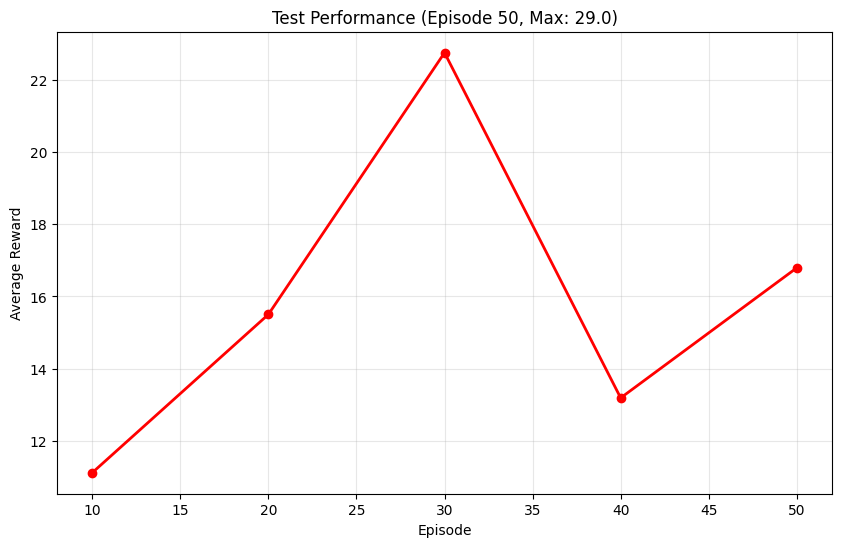

  5%|▌         | 52/1000 [07:12<3:35:19, 13.63s/it]

Training Batch 51: Collected 119 timesteps, 10 episodes


  5%|▌         | 53/1000 [07:16<2:48:42, 10.69s/it]

Training Batch 52: Collected 105 timesteps, 10 episodes


  5%|▌         | 54/1000 [07:19<2:12:18,  8.39s/it]

Training Batch 53: Collected 83 timesteps, 10 episodes


  6%|▌         | 55/1000 [07:25<2:02:13,  7.76s/it]

Training Batch 54: Collected 149 timesteps, 10 episodes


  6%|▌         | 56/1000 [07:30<1:45:32,  6.71s/it]

Training Batch 55: Collected 117 timesteps, 10 episodes


  6%|▌         | 57/1000 [07:36<1:43:19,  6.57s/it]

Training Batch 56: Collected 145 timesteps, 10 episodes


  6%|▌         | 58/1000 [07:42<1:39:49,  6.36s/it]

Training Batch 57: Collected 160 timesteps, 10 episodes


  6%|▌         | 59/1000 [07:47<1:31:52,  5.86s/it]

Training Batch 58: Collected 124 timesteps, 10 episodes


  6%|▌         | 60/1000 [07:52<1:28:57,  5.68s/it]

Training Batch 59: Collected 124 timesteps, 10 episodes
Training Batch 60: Collected 87 timesteps, 10 episodes


  6%|▌         | 61/1000 [08:31<4:04:50, 15.64s/it]

Episode 60: Avg Test Reward = 174.55, Max Test Reward = 295.52


  6%|▌         | 62/1000 [08:33<3:04:15, 11.79s/it]

Training Batch 61: Collected 74 timesteps, 10 episodes


  6%|▋         | 63/1000 [08:41<2:42:02, 10.38s/it]

Training Batch 62: Collected 169 timesteps, 10 episodes


  6%|▋         | 64/1000 [08:44<2:11:35,  8.44s/it]

Training Batch 63: Collected 107 timesteps, 10 episodes


  6%|▋         | 65/1000 [08:48<1:50:22,  7.08s/it]

Training Batch 64: Collected 103 timesteps, 10 episodes


  7%|▋         | 66/1000 [08:52<1:35:50,  6.16s/it]

Training Batch 65: Collected 86 timesteps, 10 episodes


  7%|▋         | 67/1000 [08:57<1:28:06,  5.67s/it]

Training Batch 66: Collected 122 timesteps, 10 episodes


  7%|▋         | 68/1000 [09:01<1:22:55,  5.34s/it]

Training Batch 67: Collected 116 timesteps, 10 episodes


  7%|▋         | 69/1000 [09:05<1:14:59,  4.83s/it]

Training Batch 68: Collected 85 timesteps, 10 episodes


  7%|▋         | 70/1000 [09:10<1:16:50,  4.96s/it]

Training Batch 69: Collected 148 timesteps, 10 episodes
Training Batch 70: Collected 82 timesteps, 10 episodes


  7%|▋         | 71/1000 [09:42<3:20:16, 12.93s/it]

Episode 70: Avg Test Reward = 210.56, Max Test Reward = 232.69


  7%|▋         | 72/1000 [09:46<2:37:04, 10.16s/it]

Training Batch 71: Collected 100 timesteps, 10 episodes


  7%|▋         | 73/1000 [09:50<2:09:15,  8.37s/it]

Training Batch 72: Collected 116 timesteps, 10 episodes


  7%|▋         | 74/1000 [09:54<1:50:47,  7.18s/it]

Training Batch 73: Collected 93 timesteps, 10 episodes


  8%|▊         | 75/1000 [09:59<1:38:26,  6.39s/it]

Training Batch 74: Collected 128 timesteps, 10 episodes


  8%|▊         | 76/1000 [10:01<1:21:16,  5.28s/it]

Training Batch 75: Collected 72 timesteps, 10 episodes


  8%|▊         | 77/1000 [10:05<1:15:23,  4.90s/it]

Training Batch 76: Collected 79 timesteps, 10 episodes


  8%|▊         | 78/1000 [10:09<1:08:09,  4.43s/it]

Training Batch 77: Collected 92 timesteps, 10 episodes


  8%|▊         | 79/1000 [10:12<1:04:05,  4.18s/it]

Training Batch 78: Collected 93 timesteps, 10 episodes


  8%|▊         | 80/1000 [10:18<1:11:14,  4.65s/it]

Training Batch 79: Collected 131 timesteps, 10 episodes
Training Batch 80: Collected 113 timesteps, 10 episodes


  8%|▊         | 81/1000 [10:49<3:14:01, 12.67s/it]

Episode 80: Avg Test Reward = 218.06, Max Test Reward = 239.76


  8%|▊         | 82/1000 [10:54<2:37:29, 10.29s/it]

Training Batch 81: Collected 106 timesteps, 10 episodes


  8%|▊         | 83/1000 [10:58<2:07:56,  8.37s/it]

Training Batch 82: Collected 107 timesteps, 10 episodes


  8%|▊         | 84/1000 [11:03<1:51:58,  7.33s/it]

Training Batch 83: Collected 136 timesteps, 10 episodes


  8%|▊         | 85/1000 [11:08<1:42:32,  6.72s/it]

Training Batch 84: Collected 122 timesteps, 10 episodes


  9%|▊         | 86/1000 [11:11<1:23:34,  5.49s/it]

Training Batch 85: Collected 69 timesteps, 10 episodes


  9%|▊         | 87/1000 [11:15<1:18:10,  5.14s/it]

Training Batch 86: Collected 120 timesteps, 10 episodes


  9%|▉         | 88/1000 [11:19<1:12:58,  4.80s/it]

Training Batch 87: Collected 84 timesteps, 10 episodes


  9%|▉         | 89/1000 [11:24<1:14:25,  4.90s/it]

Training Batch 88: Collected 145 timesteps, 10 episodes


  9%|▉         | 90/1000 [11:29<1:13:23,  4.84s/it]

Training Batch 89: Collected 131 timesteps, 10 episodes
Training Batch 90: Collected 136 timesteps, 10 episodes


  9%|▉         | 91/1000 [11:59<3:07:43, 12.39s/it]

Episode 90: Avg Test Reward = 187.35, Max Test Reward = 204.16


  9%|▉         | 92/1000 [12:03<2:29:49,  9.90s/it]

Training Batch 91: Collected 113 timesteps, 10 episodes


  9%|▉         | 93/1000 [12:07<2:03:00,  8.14s/it]

Training Batch 92: Collected 103 timesteps, 10 episodes


/tmp/ipython-input-25-970632852.py:202: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = F.mse_loss(returns, value.squeeze())
  9%|▉         | 94/1000 [12:12<1:49:34,  7.26s/it]

Training Batch 93: Collected 129 timesteps, 10 episodes


 10%|▉         | 95/1000 [12:15<1:26:10,  5.71s/it]

Training Batch 94: Collected 54 timesteps, 10 episodes


 10%|▉         | 96/1000 [12:19<1:18:27,  5.21s/it]

Training Batch 95: Collected 115 timesteps, 10 episodes


 10%|▉         | 97/1000 [12:24<1:17:41,  5.16s/it]

Training Batch 96: Collected 114 timesteps, 10 episodes


 10%|▉         | 98/1000 [12:29<1:16:56,  5.12s/it]

Training Batch 97: Collected 141 timesteps, 10 episodes


 10%|▉         | 99/1000 [12:34<1:17:37,  5.17s/it]

Training Batch 98: Collected 123 timesteps, 10 episodes


 10%|█         | 100/1000 [12:37<1:06:05,  4.41s/it]

Training Batch 99: Collected 71 timesteps, 10 episodes
Training Batch 100: Collected 111 timesteps, 10 episodes
Episode 100: Avg Test Reward = 180.14, Max Test Reward = 185.19


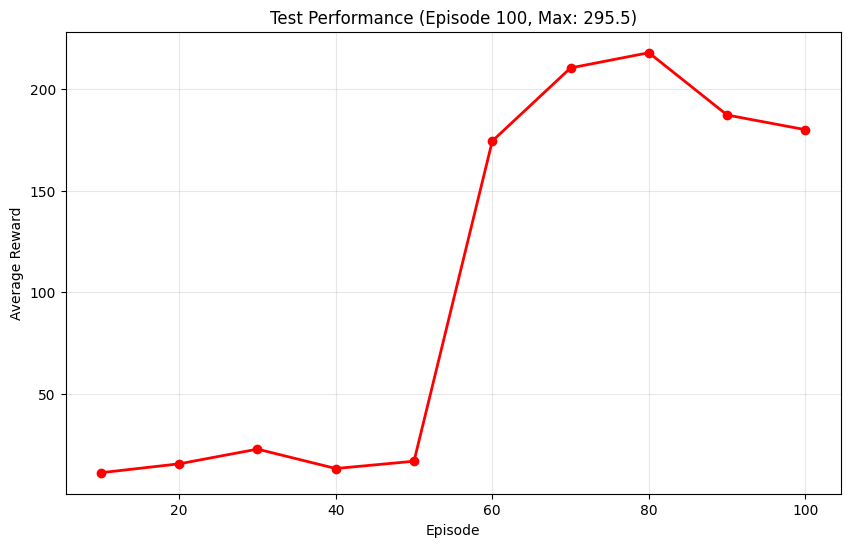

 10%|█         | 102/1000 [13:10<2:21:43,  9.47s/it]

Training Batch 101: Collected 102 timesteps, 10 episodes


 10%|█         | 103/1000 [13:13<1:55:32,  7.73s/it]

Training Batch 102: Collected 92 timesteps, 10 episodes


 10%|█         | 104/1000 [13:17<1:37:20,  6.52s/it]

Training Batch 103: Collected 102 timesteps, 10 episodes


 10%|█         | 105/1000 [13:21<1:24:12,  5.65s/it]

Training Batch 104: Collected 101 timesteps, 10 episodes


 11%|█         | 106/1000 [13:25<1:19:46,  5.35s/it]

Training Batch 105: Collected 104 timesteps, 10 episodes


 11%|█         | 107/1000 [13:29<1:13:11,  4.92s/it]

Training Batch 106: Collected 109 timesteps, 10 episodes


 11%|█         | 108/1000 [13:34<1:14:54,  5.04s/it]

Training Batch 107: Collected 134 timesteps, 10 episodes


 11%|█         | 109/1000 [13:39<1:11:16,  4.80s/it]

Training Batch 108: Collected 109 timesteps, 10 episodes


 11%|█         | 110/1000 [13:43<1:07:21,  4.54s/it]

Training Batch 109: Collected 109 timesteps, 10 episodes
Training Batch 110: Collected 102 timesteps, 10 episodes


 11%|█         | 111/1000 [14:12<2:58:25, 12.04s/it]

Episode 110: Avg Test Reward = 183.54, Max Test Reward = 208.71


 11%|█         | 111/1000 [14:16<1:54:18,  7.71s/it]


ValueError: Expected parameter loc (Tensor of shape (64, 1)) of distribution Normal(loc: torch.Size([64, 1]), scale: torch.Size([64, 1])) to satisfy the constraint Real(), but found invalid values:
tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [25]:
# Define hyperparameters
T = 1000  # Max timesteps per rollout
K = 10    # Number of policy update epochs

batch_size = 64
gamma = 0.99
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vf_coeff_cl = 0.5
ent_coef_c2 = 0.01
nb_episodes = 1000
epsilon = 0.2
gae_lambda = 0.99
max_episodes_per_rollout = 10

# Define action dimension (continuous action space)
action_dim = 1  # For lateral acceleration

# Initialize model and optimizer
model = ActorCritic(state_dim=state_dim, action_dim=action_dim).to(device)
actor_params = list(model.shared.parameters()) + list(model.actor_mean.parameters()) + list(model.actor_log_std.parameters())
critic_params = list(model.critic.parameters())

actor_optimizer = torch.optim.Adam(actor_params, lr=3e-4)
critic_optimizer = torch.optim.Adam(critic_params, lr=1e-3)

# Tracking variables
total_env_episodes = 0
max_reward = float('-inf')
batch_average_reward_history = []
batch_episode_history = []
individual_test_rewards = []
individual_test_episodes = []

# Training loop
for episode in tqdm.tqdm(range(nb_episodes)):

    # PPO Initialization
    advantages = torch.zeros(T, dtype=torch.float32, device=device)
    buffer_states = torch.zeros((T, state_dim), dtype=torch.float32, device=device)
    buffer_actions = torch.zeros((T, action_dim), dtype=torch.float32, device=device)
    buffer_log_probs = torch.zeros((T), dtype=torch.float32, device=device)
    buffer_state_values = torch.zeros((T+1), dtype=torch.float32, device=device)
    buffer_rewards = torch.zeros((T), dtype=torch.float32, device=device)
    buffer_is_terminal = torch.zeros((T), dtype=torch.float32, device=device)

    # Episode control variables
    episodes_completed_in_rollout = 0
    t = 0  # Actual timesteps collected

    # Env Initialization
    obs, _ = env.reset()
    state_manager.update(obs)

    # Initialize target_id
    target_id = env.unwrapped.vehicle.lane_index[-1]
    agent_state = state_manager.ego_state_agent(target_id=target_id)

    episode_step = 0
    episode_return = 0.0
    done = False
    obs_old = obs

    # Collect trajectories with dual stopping condition
    while episodes_completed_in_rollout < max_episodes_per_rollout:
      while not done:
        gap_control = Gap_Controller(obs, following_gap_threshold=30)
        activated_target_lane = gap_control.lane_checker()

        # Determine target lane
        target_id = activated_target_lane
        agent_state = state_manager.ego_state_agent(target_id=target_id)

        # Convert agent state dict to tensor
        state_tensor = torch.tensor(
            [agent_state[key] for key in ['vx', 'longitudinal_acceleration', 'x', 'y', 'thetha', 'lane_id', 'lane_width', 'self_curvature']],
            dtype=torch.float32, device=device
        ).unsqueeze(0)

        # Get action and value from model
        with torch.no_grad():
            agent_action, log_prob, value = model.action(state_tensor)
            action = state_manager.action(obs,agent_action)

        # Take action in environment
        obs, reward, done, truncated, info = env.step(action)
        done = done or truncated

        # Terminal conditions
        if info["crashed"] or not env.unwrapped.vehicle.on_road:
            done = True

        # Update state manager with new observation and applied longitudinal control
        state_manager.update(obs)

        # Compute reward based on the new state
        reward_components = state_manager.reward_function(obs_old, obs, target_id)
        reward = reward_components[0]

        # Update episode return
        episode_return += reward

        # Store trajectory information
        buffer_states[t] = state_tensor.squeeze(0)
        buffer_actions[t] = agent_action
        buffer_log_probs[t] = log_prob
        buffer_state_values[t] = value
        buffer_rewards[t] = torch.tensor(reward, dtype=torch.float32, device=device)
        buffer_is_terminal[t] = done

        t += 1  # Increment timestep counter
        obs_old = obs

        # Update IDM inputs for next iteration
        ego_state_idm = state_manager.ego_state_idm()
        lead_state = state_manager.longitudinal_lead_state()
        gap = lead_state['x']
        delta_velocity = lead_state['vx']
        input_variables = [gap, ego_state_idm['vx'], delta_velocity]

        # If episode is done, track results and increment episode counter
        if done:
            episodes_completed_in_rollout += 1
            total_env_episodes += 1

            # Reset environment if more episodes needed
            if episodes_completed_in_rollout < max_episodes_per_rollout and t < T:
                obs, _ = env.reset()
                state_manager.update(obs)
                target_id = env.unwrapped.vehicle.lane_index[-1]
                obs_old = obs
                done = False

    # Actual number of timesteps collected
    actual_T = t

    # Get final value for bootstrapping
    if not done and actual_T > 0:
        target_id = env.unwrapped.vehicle.lane_index[-1]
        agent_state = state_manager.ego_state_agent(target_id=target_id)
        final_state_tensor = torch.tensor(
            [agent_state[key] for key in ['vx', 'longitudinal_acceleration', 'x', 'y', 'thetha', 'lane_id', 'lane_width', 'self_curvature']],
            dtype=torch.float32, device=device
        ).unsqueeze(0)

        with torch.no_grad():
            _, final_value = model(final_state_tensor)
        buffer_state_values[actual_T] = final_value.squeeze(0)

    # Calculate advantages using GAE
    gae = 0
    advantages = torch.zeros(actual_T, dtype=torch.float32, device=device)

    for t_idx in range(actual_T-1, -1, -1):
        if buffer_is_terminal[t_idx]:
            terminal = 1
            next_value = 0
        else:
            terminal = 0
            if t_idx == actual_T-1:
                next_value = buffer_state_values[actual_T]
            else:
                next_value = buffer_state_values[t_idx+1]

        delta = buffer_rewards[t_idx] + gamma * next_value * (1-terminal) - buffer_state_values[t_idx]
        gae = delta + (gamma * gae_lambda) * gae * (1-terminal)
        advantages[t_idx] = gae

    # Normalize advantages
    if actual_T > 1:
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    # Prepare data for policy update
    advantages_data_loader = DataLoader(
        TensorDataset(
            advantages.detach(),
            buffer_states[:actual_T].detach(),
            buffer_actions[:actual_T].detach(),
            buffer_log_probs[:actual_T].detach(),
            buffer_state_values[:actual_T].detach()),
        batch_size=min(batch_size, actual_T),
        shuffle=True)

    # Policy update (K epochs)
    for epoch in range(K):
        for batch_data in advantages_data_loader:
            b_adv, obs_batch, action_batch, old_log_probs, old_state_values = batch_data

            # Forward pass
            dist, value = model(obs_batch)
            log_probs = dist.log_prob(action_batch)

            # Calculate ratio
            ratio = torch.exp(log_probs - old_log_probs)
            returns = b_adv + old_state_values

            # Policy loss
            policy_loss_1 = b_adv * ratio
            policy_loss_2 = b_adv * torch.clamp(ratio, 1-epsilon, 1+epsilon)
            policy_loss = -torch.min(policy_loss_1, policy_loss_2).mean()

            actor_loss = policy_loss - ent_coef_c2 * dist.entropy().mean()
            critic_loss = F.mse_loss(returns, value.squeeze())

            # Optimize
            # For the actor:
            actor_optimizer.zero_grad() # Clear gradients for actor
            actor_loss.backward()       # Compute gradients for actor_loss w.r.t. actor_params
            actor_optimizer.step()      # Update actor_params

            # For the critic:
            critic_optimizer.zero_grad() # Clear gradients for critic
            critic_loss.backward()       # Compute gradients for critic_loss w.r.t. critic_params
            critic_optimizer.step()

    # Print rollout info
    print(f"Training Batch {episode}: Collected {actual_T} timesteps, {episodes_completed_in_rollout} episodes")

    # Testing every 10 episodes
    if episode % 10 == 0 and episode > 0:
        test_rewards = []

        for test_ep in range(3):  # Reduced to 3 test episodes for speed
            obs, _ = env.reset()
            state_manager = ENV(obs,control_parameters=control_parameters,desired_parameters=desired_parameters)
            episode_reward = 0
            done = False
            test_steps = 0

            while not done and test_steps < 500:  # Limit test episode length
                target_id = env.unwrapped.vehicle.lane_index[-1]
                agent_state = state_manager.ego_state_agent(target_id=target_id)

                state_tensor = torch.tensor(
                    [agent_state[key] for key in ['vx', 'longitudinal_acceleration', 'x', 'y', 'thetha', 'lane_id', 'lane_width', 'self_curvature']],
                    dtype=torch.float32, device=device
                ).unsqueeze(0)

                with torch.no_grad():
                    agent_action, log_prob, value = model.action(state_tensor,deterministic=True)

                action = state_manager.action(obs, agent_action)

                obs, reward, done, truncated, info = env.step(action)
                done = done or truncated
                state_manager.update(obs)

                episode_reward += reward
                test_steps += 1

            test_rewards.append(episode_reward)

        avg_test_reward = sum(test_rewards) / len(test_rewards)
        current_max = max(test_rewards)

        if current_max > max_reward:
            max_reward = current_max

        batch_average_reward_history.append(avg_test_reward)
        batch_episode_history.append(episode)

        print(f"Episode {episode}: Avg Test Reward = {avg_test_reward:.2f}, Max Test Reward = {current_max:.2f}")

    # Plot every 50 episodes
    if episode % 50 == 0 and episode > 0 and batch_average_reward_history:
        plt.figure(figsize=(10, 6))
        plt.plot(batch_episode_history, batch_average_reward_history, 'r-o', linewidth=2)
        plt.title(f"Test Performance (Episode {episode}, Max: {max_reward:.1f})")
        plt.xlabel("Episode")
        plt.ylabel("Average Reward")
        plt.grid(True, alpha=0.3)
        plt.show()

print("Training completed!")